# 분류 알고리즘

{'C': 0.1, 'gamma': 1, 'kernel': 'rbf'}
              precision    recall  f1-score   support

           C       1.00      0.91      0.95        11
          SG       0.90      1.00      0.95         9

    accuracy                           0.95        20
   macro avg       0.95      0.95      0.95        20
weighted avg       0.96      0.95      0.95        20


accuracy :0.95


,prediction,ground_truth
0,C,C
1,SG,SG
2,C,C
3,SG,SG
4,C,C
5,C,C
6,C,C
7,SG,SG
8,SG,SG
9,C,C


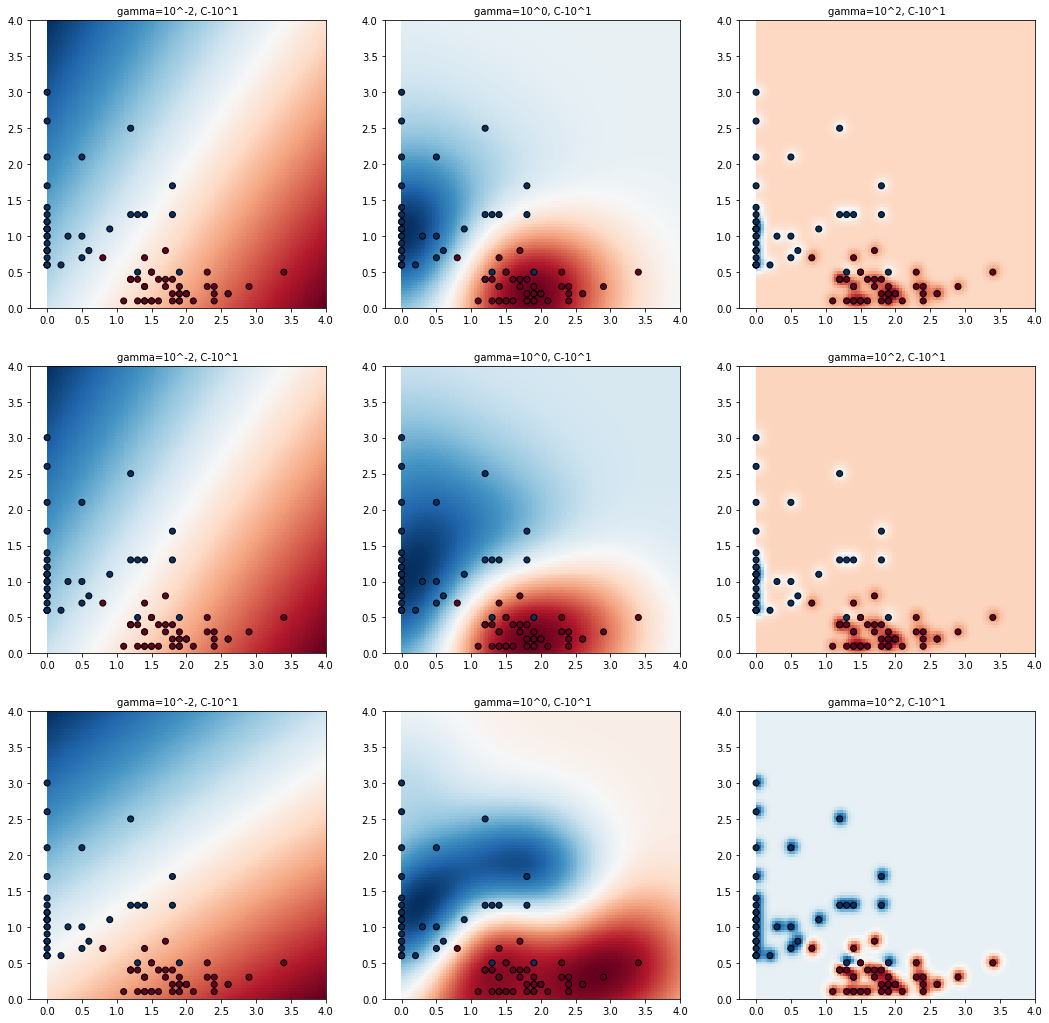

In [45]:
import pandas as pd
import pickle   #파이썬 객체를 파일로 저장하는 것
import matplotlib.pyplot as plt
import seaborn as snn
import numpy as np

get_ipython().run_line_magic('matplotlib', 'inline')
np.random.seed(5)

train = pd.read_csv("basketball_train.csv") 
test = pd.read_csv("basketball_test.csv")

from sklearn.model_selection import GridSearchCV  #정확히 분류할 수 있는 경계선을 찾는 것
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC

import numpy as np

#SVM 최적의 파라미터 찾기
#SVM의 파라미터는 두가지가 있다.
# 1. C : 비용 (cost), 결정경계썬의 마진을 결정하는 파라미터
# 2. gamma : 커널의 데이터포인트의 표준편차를 결정한느 파라미터
# 결과적으로 C 가 클수록, 결정경계선과 서포트 벡터의 간격(마진)이 작아집니다.
# 결과적으로 gamma가 클수록, 결정경계선이 데이터포인트와 더욱 가까워집니다.


####하지만 Gridseach를 통해 C, gamma 최적의 값을 쉽게 구할 수 있다.


#가운데 임의의 선을 하나 그어서 양쪽의 거리를 잰다. 결정 경계선과 가장 떨어져있는 요소를 찾는다.
#결정 경계선과 연결되는, 관계있는 것들을 서포트 벡터라고 말한다. 벡터형식으로 연결되기 때문에
#결정 경계선과 결정 경계선과의 사이를 '마진(간격)' 이라고 하는데
#마진이 최대가 되면, (가장 긴 경우를 찾아서) 그곳의 결정 경계선을 찾아 두개의 경계선을 나누는 것을
#서포트 벡터라고 한다.
#초평면과 경계 결정선,면에 대해서 구글링 한번 해볼 것

def svc_param_selection(X, y, nfolds):
    svm_parameters = [
                        {'kernel': ['rbf'],
                        'gamma': [0.00001,0.00001,0.001,0.01,0.1, 1],
                        'C' : [0.01,0.1,1,10,100,1000]
                        }
                        ]
    clf = GridSearchCV(SVC(), svm_parameters, cv=10)
    clf.fit(X_train, y_train.values.ravel())
    print(clf.best_params_)
    
    return clf

X_train = train[['3P', 'BLK']]
y_train = train[['Pos']]

# 최적의 파라미터를 sklearn의 gridsearch를 통해 구한다.
clf = svc_param_selection(X_train, y_train, 10)

#시각화
# 최적의 파라미터일때의 결정경계선과 다른 파라미터들일때의 결정경계선을 비교해봅시다.

#시각화를 위해, 최적의 C 후보를 저장합니다..

C_canditates = []
C_canditates.append(clf.best_params_['C'] * 0.01)
C_canditates.append(clf.best_params_['C'])
C_canditates.append(clf.best_params_['C'] * 100)

#시각화를 하기 위해, 최적의 gamma 후보를 저장합니다.

gamma_candidates = []
gamma_candidates.append(clf.best_params_['gamma'] * 0.01)
gamma_candidates.append(clf.best_params_['gamma'])
gamma_candidates.append(clf.best_params_['gamma'] * 100)

X = train[['3P', 'BLK']]
Y = train['Pos'].tolist()

#포지션에 해당하는 문자열 SG와 C를 벡터화합니다.
position = []
for gt in Y:
    if gt == 'C':
        position.append(0)
    else:
        position.append(1)
        
classifiers = []
for C in C_canditates:
    for gamma in gamma_candidates:
        clf = SVC(C=C, gamma=gamma)
        clf.fit(X, Y)
        classifiers.append((C, gamma, clf))
        
#18,18 사이즈의 차트를 구성합니다.
plt.figure(figsize=(18,18))
xx, yy = np.meshgrid(np.linspace(0,4,100), np.linspace(0,4,100))

for(k, (c, gamma, clf)) in enumerate(classifiers):
    Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    #최적의 모델을 포함한 다른 파라미터로 학습된 모델들을 함께 시각화해본다.
    plt.subplot(len(C_canditates), len(gamma_candidates), k + 1)
    plt.title("gamma=10^%d, C-10^%d" % (np.log10(gamma), np.log10(C)), size='medium')
    
    #서포트 벡터와 결정경계선을 시각화합니다.
    plt.pcolormesh(xx, yy, -Z, cmap=plt.cm.RdBu)
    plt.scatter(X['3P'], X['BLK'], c=position, cmap=plt.cm.RdBu_r, edgecolors='k')
    
X_test = test[['3P', 'BLK']]
y_test = test[['Pos']]

y_true, y_pred = y_test, clf.predict(X_test)

print(classification_report(y_true, y_pred))
print()
print("accuracy :" + str(accuracy_score(y_true, y_pred)))

comparison = pd.DataFrame({'prediction':y_pred, 'ground_truth': y_true.values.ravel()})
comparison

{'C': 0.1, 'gamma': 1, 'kernel': 'rbf'}


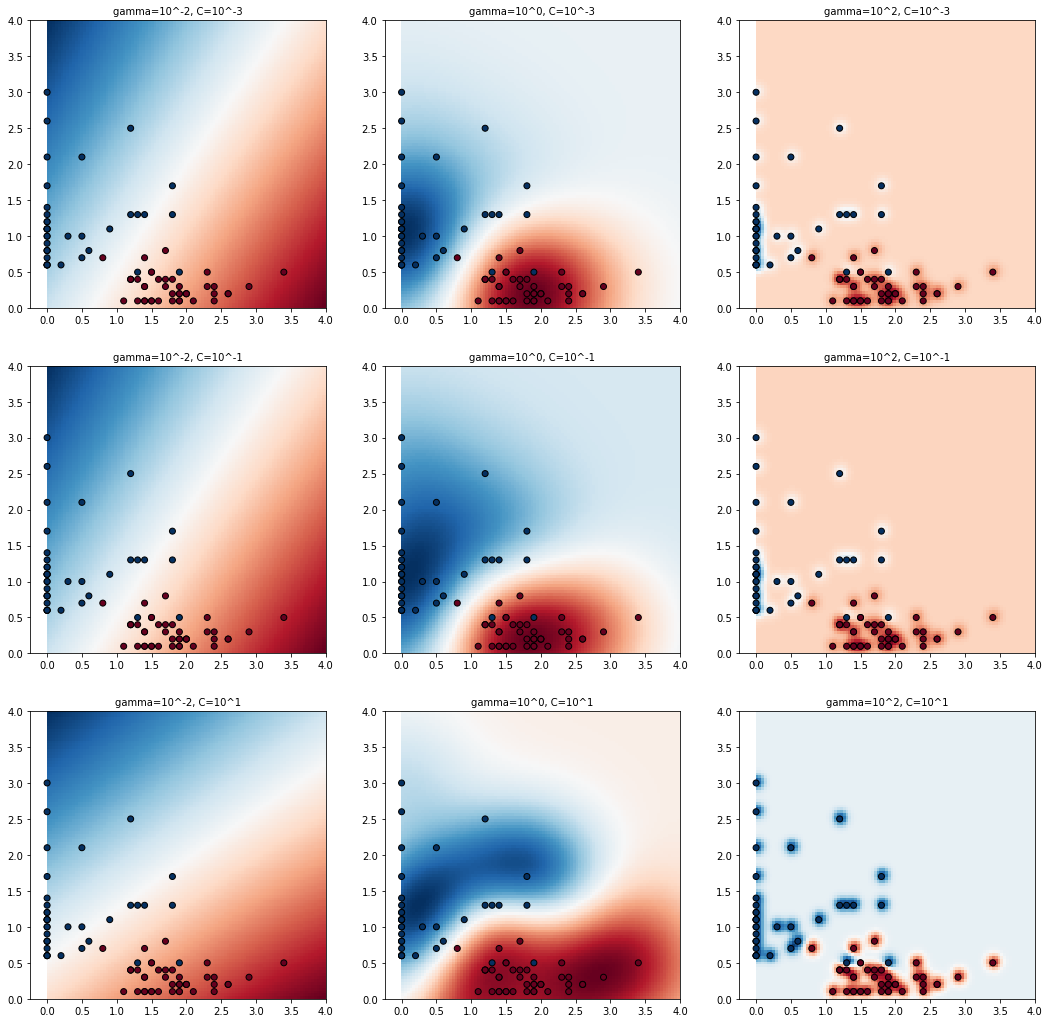

In [38]:
import pandas as pd
import pickle  # python 객체를 파일로 저장하기 위해 사용하는 module
import matplotlib.pyplot as plt
import seaborn as sns  # 시각화 모듈
import numpy as np

# 그래프 출력
get_ipython().run_line_magic('matplotlib', 'inline')

# sklearn 모델의 동일한 결과 출력을 위해 선언합니다.
np.random.seed(5)

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, accuracy_score
from sklearn.svm import SVC

import numpy as np

# sklearn에서 제공하는 gridsearch를 사용하면, 손쉽게 최적의 C, gamma를 구할 수 있다.

def svc_param_selection(X_train, y_train, nfolds):
    svm_parameters = [
        {
            'kernel': ['rbf'],
            'gamma': [0.00001, 0.0001, 0.001, 0.01, 0.1, 1],
            'C': [0.01, 0.1, 1, 10, 100, 1000]
        }
    ]
    
    clf = GridSearchCV(SVC(), svm_parameters, cv=10)
    clf.fit(X_train, y_train.values.ravel())
    print(clf.best_params_)
    
    return clf


X_train = train[['3P', 'BLK']]
y_train = train[['Pos']]

# 최적의 파라미터를 sklearn의 gridsearch를 통해 구한다.
clf = svc_param_selection(X_train, y_train, 10)

# 시각화를 하기 위해, 최적의 C 후보를 저장
C_candidates = []
C_candidates.append(clf.best_params_['C'] * 0.01)
C_candidates.append(clf.best_params_['C'])
C_candidates.append(clf.best_params_['C'] * 100)

# 시각화를 하기 위해, 최적의 gamma 후보를 저장
gamma_candidates = []
gamma_candidates.append(clf.best_params_['gamma'] * 0.01)
gamma_candidates.append(clf.best_params_['gamma'])
gamma_candidates.append(clf.best_params_['gamma'] * 100)

X = train[['3P', 'BLK']]
Y = train['Pos'].tolist()

# 포지션에 해당하는 문자열 SG와 C를 벡터화한다.
position = []
for gt in Y:
    if gt == 'C':
        position.append(0)
    else:
        position.append(1)
		
		
# 각각의 파라미터에 해당하는 SVM 모델을 만들어 classifiers에 저장한다.
classifiers = []
for C in C_candidates:
    for gamma in gamma_candidates:
        clf = SVC(C=C, gamma=gamma)
        clf.fit(X, Y)
        classifiers.append((C, gamma, clf))

# 18, 18 사이즈의 차트를 구성한다.
plt.figure(figsize=(18, 18))
xx, yy = np.meshgrid(np.linspace(0, 4, 100), np.linspace(0, 4, 100))

# 각각의 모델들에 대한 결정 경계 함수를 적용하여 함께 시각화한다.
for (k, (C, gamma, clf)) in enumerate(classifiers):
    Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    # 최적의 모델을 포함한 다른 파라미터로 학습된 모델들을 함께 시각화 해본다.
    plt.subplot(len(C_candidates), len(gamma_candidates), k + 1)
    plt.title("gamma=10^%d, C=10^%d" % (np.log10(gamma), np.log10(C)), size='medium')
    
    # Support Vector와 결정경계선을 시각화한다.
    plt.pcolormesh(xx, yy, -Z, cmap=plt.cm.RdBu)
    plt.scatter(X['3P'], X['BLK'], c=position, cmap=plt.cm.RdBu_r, edgecolors='k')